In [ ]:
#jinay60009210188
import numpy as np
import pandas as pd
import math

In [ ]:
df = pd.read_csv('/content/PlayTennis.csv')
df

,outlook,temp,humidity,windy,play
0,sunny,hot,high,False,no
1,sunny,hot,high,True,no
2,overcast,hot,high,False,yes
3,rainy,mild,high,False,yes
4,rainy,cool,normal,False,yes
5,rainy,cool,normal,True,no
6,overcast,cool,normal,True,yes
7,sunny,mild,high,False,no
8,sunny,cool,normal,False,yes
9,rainy,mild,normal,False,yes


In [ ]:

df['outlook'] = df['outlook'].replace(['sunny', 'overcast', 'rainy'], [2,0,1])
df['temp'] = df['temp'].replace(['hot', 'mild', 'cool'], [1,2,0])
df['humidity'] = df['humidity'].replace(['high', 'normal'], [0,1])
df['windy'] = df['windy'].replace([False, True], [0,1])
df['play'] = df['play'].replace(['no', 'yes'], [0, 1])
df

,outlook,temp,humidity,windy,play
0,2,1,0,0,0
1,2,1,0,1,0
2,0,1,0,0,1
3,1,2,0,0,1
4,1,0,1,0,1
5,1,0,1,1,0
6,0,0,1,1,1
7,2,2,0,0,0
8,2,0,1,0,1
9,1,2,1,0,1


In [ ]:
X = df.iloc[:,:-1].values
Y = df.iloc[:, -1].values.reshape(-1,1)
feature_list = ['outlook', 'temp', 'humidity', 'windy']
target = 'play'
df['outlook'].unique()

array([2, 0, 1])

# Creating Tree And Node

In [ ]:
class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, information_gain=None, value=None):

        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.information_gain = information_gain


        self.value = value

In [ ]:
class Tree:
    def __init__(self, min_samples_split=2, max_depth=3, mode="entropy"):

        self.root = None
        self.mode = mode

        self.min_samples_split = min_samples_split
        self.max_depth = max_depth

    def build_tree(self, dfset, curr_depth=0):
        X, Y = dfset[:,:-1], dfset[:,-1]
        num_samples, num_features = np.shape(X)


        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:

            best_split = self.get_best_split(dfset, num_samples, num_features)

            if best_split["information_gain"]>0:

                left_subtree = self.build_tree(best_split["dfset_left"], curr_depth+1)

                right_subtree = self.build_tree(best_split["dfset_right"], curr_depth+1)

                return Node(best_split["feature_index"], best_split["threshold"],
                            left_subtree, right_subtree, best_split["information_gain"])


        z = list(Y)
        leaf_value = max(z, key=z.count)

        return Node(value=leaf_value)

    def get_best_split(self, dfset, num_samples, num_features):


        best_split = {}
        max_information_gain = -float("inf")


        for feature_index in range(num_features):
            feature_values = dfset[:, feature_index]
            possible_thresholds = np.unique(feature_values)

            for threshold in possible_thresholds:

                dfset_left, dfset_right = self.split(dfset, feature_index, threshold)

                if len(dfset_left)>0 and len(dfset_right)>0:
                    y, left_y, right_y = dfset[:, -1], dfset_left[:, -1], dfset_right[:, -1]

                    curr_information_gain = self.information_gain(y, left_y, right_y)

                    if curr_information_gain>max_information_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dfset_left"] = dfset_left
                        best_split["dfset_right"] = dfset_right
                        best_split["information_gain"] = curr_information_gain
                        max_information_gain = curr_information_gain

        return best_split

    def split(self, dfset, feature_index, threshold):
        dfset_left = np.array([row for row in dfset if row[feature_index]<=threshold])
        dfset_right = np.array([row for row in dfset if row[feature_index]>threshold])
        return dfset_left, dfset_right

    def information_gain(self, parent, l_child, r_child):

        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if self.mode=="gini":
            gain = self.gini_index(parent) - (weight_l*self.gini_index(l_child) + weight_r*self.gini_index(r_child))
        else:
            gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
        return gain

    def entropy(self, y):

        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy

    def gini_index(self, y):

        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2
        return 1 - gini

    def print_tree(self, tree=None, indent=" "):
        ''' function to print the tree '''
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(feature_list[tree.feature_index]), "<=", tree.threshold, "?", tree.information_gain)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)

    def fit(self, X, Y):
        dfset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dfset)

    def predict(self, X):
        preditions = [self.prediction(x, self.root) for x in X]
        return preditions

    def prediction(self, x, tree):

        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.prediction(x, tree.left)
        else:
            return self.prediction(x, tree.right)

In [ ]:
classifier = Tree(min_samples_split=3,max_depth=3, mode="gini")
classifier.fit(X,Y)
classifier.print_tree()

X_outlook <= 0 ? 0.10204081632653056
 left:1
 right:X_humidity <= 0 ? 0.18000000000000016
  left:X_outlook <= 1 ? 0.11999999999999983
    left:1
    right:0
  right:X_windy <= 0 ? 0.11999999999999983
    left:1
    right:0


In [ ]:
from sklearn import tree
classifier = tree.DecisionTreeClassifier(criterion="entropy").fit(X, Y)

[Text(0.4, 0.9, 'outlook <= 0.5\nentropy = 0.94\nsamples = 14\nvalue = [5, 9]'),
 Text(0.3, 0.7, 'entropy = 0.0\nsamples = 4\nvalue = [0, 4]'),
 Text(0.5, 0.7, 'humidity <= 0.5\nentropy = 1.0\nsamples = 10\nvalue = [5, 5]'),
 Text(0.3, 0.5, 'outlook <= 1.5\nentropy = 0.722\nsamples = 5\nvalue = [4, 1]'),
 Text(0.2, 0.3, 'windy <= 0.5\nentropy = 1.0\nsamples = 2\nvalue = [1, 1]'),
 Text(0.1, 0.1, 'entropy = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.3, 0.1, 'entropy = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.4, 0.3, 'entropy = 0.0\nsamples = 3\nvalue = [3, 0]'),
 Text(0.7, 0.5, 'windy <= 0.5\nentropy = 0.722\nsamples = 5\nvalue = [1, 4]'),
 Text(0.6, 0.3, 'entropy = 0.0\nsamples = 3\nvalue = [0, 3]'),
 Text(0.8, 0.3, 'outlook <= 1.5\nentropy = 1.0\nsamples = 2\nvalue = [1, 1]'),
 Text(0.7, 0.1, 'entropy = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.9, 0.1, 'entropy = 0.0\nsamples = 1\nvalue = [0, 1]')]

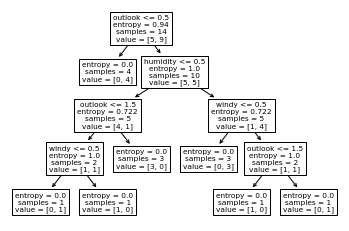

In [ ]:
tree.plot_tree(classifier, feature_names=feature_list)

# Testing

In [ ]:
y_pred = classifier.predict(X)
from sklearn.metrics import accuracy_score, confusion_matrix
cm = confusion_matrix(Y, y_pred)
print(cm)
accuracy_score(Y, y_pred)

[[5 0]
 [0 9]]


1.0